In [2]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
# Fairface
def residual_block(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Convolutions
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_block_recon(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Première convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    shortcut = tf.keras.layers.Conv2DTranspose(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def create_resnet_autoencoder(input_latent=512):
    input_img = tf.keras.Input(shape=(150, 150, 1))
    x = tf.keras.layers.Conv2D(16, 3, strides=2, padding='same', use_bias=False)(input_img)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

    # Encodeur
    x = residual_block(x, 32, 3, 2)
    x = residual_block(x, 64, 3, 2)
    x = residual_block(x, 128, 3, 2)
    x = residual_block(x, 256, 3, 2)
    x = residual_block(x, 512, 3, 2)
    x = residual_block(x, 1024, 3, 2)
    x = residual_block(x, 2048, 3, 2)
    x = residual_block(x, input_latent, 3, 1)
    x = tf.keras.layers.Flatten()(x)
    latent_space_layer = tf.keras.layers.Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = tf.keras.layers.BatchNormalization(name='latent_space_layer_norm')(x)

    # Décodeur
    reshape_layer = tf.keras.layers.Reshape(target_shape=(1,1,input_latent))(latent_space_layer_norm)
    x_recon = residual_block_recon(reshape_layer, input_latent, 3, 1)
    x_recon = residual_block_recon(x_recon, 2048, 3, 2)
    x_recon = residual_block_recon(x_recon, 1024, 3, 2)
    x_recon = residual_block_recon(x_recon, 512, 3, 2)
    x_recon = residual_block_recon(x_recon, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 128, 3, 2)
    x_recon = residual_block_recon(x_recon, 64, 3, 2)
    x_recon = residual_block_recon(x_recon, 32, 3, 2)
    
    x_recon = residual_block_recon(x_recon, 16, 3, 2)
    x_recon = tf.keras.layers.Conv2DTranspose(1, 1, activation='sigmoid', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.Resizing(150, 150)(x_recon)
    model = tf.keras.Model(inputs=input_img, outputs=x_recon)
    lr1 = 0.01
    lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr1, decay_steps=42237,decay_rate=0.5,staircase=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule1, momentum = 0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    model.summary()
    return model

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
dataset_white = train_datagen.flow_from_directory(
    '../../Datasets_FairFace/train',
    classes=['White'],
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='input',
    color_mode='grayscale')
testset_white = train_datagen.flow_from_directory(
    '../../Datasets_FairFace/val',
    classes=['White'],
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='input',
    color_mode='grayscale')
dataset_east_asian = train_datagen.flow_from_directory(
    '../../Datasets_FairFace/train',
    classes=['East Asian'],
    target_size=(150, 150),
    batch_size=32,
    class_mode='input',
    color_mode='grayscale')
dataset_east_asian = train_datagen.flow_from_directory(
    '../../Datasets_FairFace/val',
    classes=['East Asian'],
    target_size=(150, 150),
    batch_size=32,
    class_mode='input',
    color_mode='grayscale')
dataset_mixed = train_datagen.flow_from_directory(
    '../../Datasets_FairFace/train',
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary',
    color_mode='grayscale')
dataset_mixed = train_datagen.flow_from_directory(
    '../../Datasets_FairFace/val',
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary',
    color_mode='grayscale')

Found 12287 images belonging to 1 classes.
Found 2085 images belonging to 1 classes.
Found 12278 images belonging to 1 classes.
Found 1550 images belonging to 1 classes.
Found 24565 images belonging to 2 classes.
Found 3635 images belonging to 2 classes.


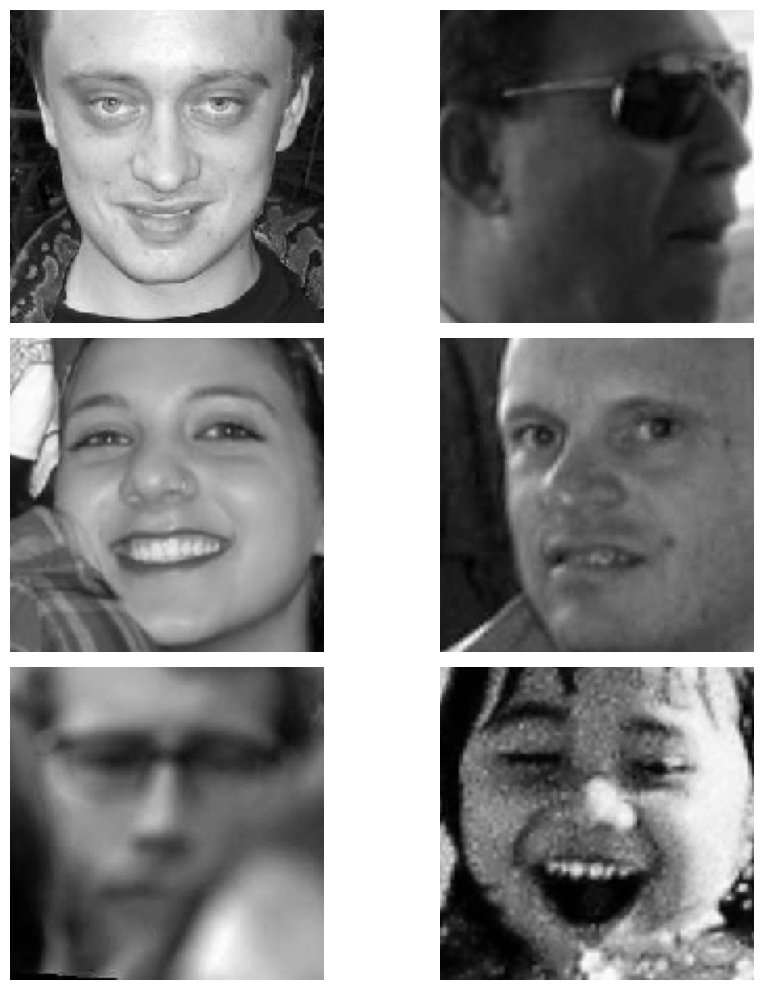

: 

In [5]:
# Récupérer un lot d'images du générateur
batch = next(dataset_white)

# Extraire les images et les étiquettes du lot
images = batch[0]
labels = batch[1]

num_rows = 3
num_cols = 2

plt.figure(figsize=(10, 10))
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[i].reshape((150,150)), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
shape = (150, 150,1)
input_latent = 256 #nombre de dimensions de l'espace latent, celui dont on veut qu'il modélise le face space de Tim Valentine donc
model = create_resnet_autoencoder()
chekpoint_path = 'stim_autoencoder.hdf5'
checkpoint_callback = ModelCheckpoint(
    filepath=chekpoint_path,
    save_weights_only=False,
    save_frequency='epoch',
    save_best_only=True
    )

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_50 (Conv2D)             (None, 75, 75, 16)   144         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_104 (Batch  (None, 75, 75, 16)  64          ['conv2d_50[0][0]']              
 Normalization)                                                                                   
                                                                                            

In [16]:
history = model.fit(x=dataset_white, epochs=10000, batch_size=64, validation_data=testset_white)

Epoch 1/10000
384/384 [==============================] - 137s 356ms/step - loss: 0.0467 - mae: 0.1757 - val_loss: 0.0429 - val_mae: 0.1686
Epoch 2/10000
384/384 [==============================] - 131s 341ms/step - loss: 0.0368 - mae: 0.1524 - val_loss: 0.0341 - val_mae: 0.1468
Epoch 3/10000
384/384 [==============================] - 131s 341ms/step - loss: 0.0304 - mae: 0.1366 - val_loss: 0.0279 - val_mae: 0.1292
Epoch 4/10000
384/384 [==============================] - 131s 342ms/step - loss: 0.0264 - mae: 0.1260 - val_loss: 0.0246 - val_mae: 0.1200
Epoch 5/10000
384/384 [==============================] - 131s 341ms/step - loss: 0.0243 - mae: 0.1201 - val_loss: 0.0227 - val_mae: 0.1154
Epoch 6/10000
384/384 [==============================] - 131s 341ms/step - loss: 0.0229 - mae: 0.1160 - val_loss: 0.0212 - val_mae: 0.1106
Epoch 7/10000
384/384 [==============================] - 131s 341ms/step - loss: 0.0219 - mae: 0.1132 - val_loss: 0.0203 - val_mae: 0.1079
Epoch 8/10000
384/384 [====

KeyboardInterrupt: 

In [17]:
get_latent = keras.Model(inputs=model.input, outputs=model.get_layer('dense_4').output)

ValueError: No such layer: dense_4. Existing layers are: ['input_3', 'conv2d_50', 'batch_normalization_104', 'activation_70', 'max_pooling2d_2', 'conv2d_51', 'batch_normalization_105', 'activation_71', 'conv2d_52', 'conv2d_53', 'batch_normalization_106', 'batch_normalization_107', 'add_34', 'activation_72', 'conv2d_54', 'batch_normalization_108', 'activation_73', 'conv2d_55', 'conv2d_56', 'batch_normalization_109', 'batch_normalization_110', 'add_35', 'activation_74', 'conv2d_57', 'batch_normalization_111', 'activation_75', 'conv2d_58', 'conv2d_59', 'batch_normalization_112', 'batch_normalization_113', 'add_36', 'activation_76', 'conv2d_60', 'batch_normalization_114', 'activation_77', 'conv2d_61', 'conv2d_62', 'batch_normalization_115', 'batch_normalization_116', 'add_37', 'activation_78', 'conv2d_63', 'batch_normalization_117', 'activation_79', 'conv2d_64', 'conv2d_65', 'batch_normalization_118', 'batch_normalization_119', 'add_38', 'activation_80', 'conv2d_66', 'batch_normalization_120', 'activation_81', 'conv2d_67', 'conv2d_68', 'batch_normalization_121', 'batch_normalization_122', 'add_39', 'activation_82', 'conv2d_69', 'batch_normalization_123', 'activation_83', 'conv2d_70', 'conv2d_71', 'batch_normalization_124', 'batch_normalization_125', 'add_40', 'activation_84', 'conv2d_72', 'batch_normalization_126', 'activation_85', 'conv2d_73', 'conv2d_74', 'batch_normalization_127', 'batch_normalization_128', 'add_41', 'activation_86', 'flatten_2', 'latent_space_layer_norm', 'reshape_2', 'conv2d_transpose_56', 'batch_normalization_129', 'activation_87', 'conv2d_transpose_57', 'conv2d_transpose_58', 'batch_normalization_130', 'batch_normalization_131', 'add_42', 'activation_88', 'conv2d_transpose_59', 'batch_normalization_132', 'activation_89', 'conv2d_transpose_60', 'conv2d_transpose_61', 'batch_normalization_133', 'batch_normalization_134', 'add_43', 'activation_90', 'conv2d_transpose_62', 'batch_normalization_135', 'activation_91', 'conv2d_transpose_63', 'conv2d_transpose_64', 'batch_normalization_136', 'batch_normalization_137', 'add_44', 'activation_92', 'conv2d_transpose_65', 'batch_normalization_138', 'activation_93', 'conv2d_transpose_66', 'conv2d_transpose_67', 'batch_normalization_139', 'batch_normalization_140', 'add_45', 'activation_94', 'conv2d_transpose_68', 'batch_normalization_141', 'activation_95', 'conv2d_transpose_69', 'conv2d_transpose_70', 'batch_normalization_142', 'batch_normalization_143', 'add_46', 'activation_96', 'conv2d_transpose_71', 'batch_normalization_144', 'activation_97', 'conv2d_transpose_72', 'conv2d_transpose_73', 'batch_normalization_145', 'batch_normalization_146', 'add_47', 'activation_98', 'conv2d_transpose_74', 'batch_normalization_147', 'activation_99', 'conv2d_transpose_75', 'conv2d_transpose_76', 'batch_normalization_148', 'batch_normalization_149', 'add_48', 'activation_100', 'conv2d_transpose_77', 'batch_normalization_150', 'activation_101', 'conv2d_transpose_78', 'conv2d_transpose_79', 'batch_normalization_151', 'batch_normalization_152', 'add_49', 'activation_102', 'conv2d_transpose_80', 'batch_normalization_153', 'activation_103', 'conv2d_transpose_81', 'conv2d_transpose_82', 'batch_normalization_154', 'batch_normalization_155', 'add_50', 'activation_104', 'conv2d_transpose_83', 'resizing_2'].

In [18]:
X_train, y_train = next(dataset_east_asian)
X_train1, y_train = next(dataset_east_asian)
X_train2, _ = next(dataset_east_asian)
X_train3, _ = next(dataset_east_asian)
east_asian = np.concatenate((X_train,X_train1,X_train2,X_train3), axis=0)
latent_representations = get_latent.predict(east_asian)

NameError: name 'get_latent' is not defined

In [56]:
X_train, y_train = next(dataset_white)
X_train1, y_train = next(dataset_white)
X_train2, _ = next(dataset_white)
X_train3, _ = next(dataset_white)
white = np.concatenate((X_train,X_train1,X_train2,X_train3), axis=0)
latent_representations2 = get_latent.predict(white)

2/2 [==============================] - 0s 47ms/step


2/2 [==============================] - 0s 150ms/step


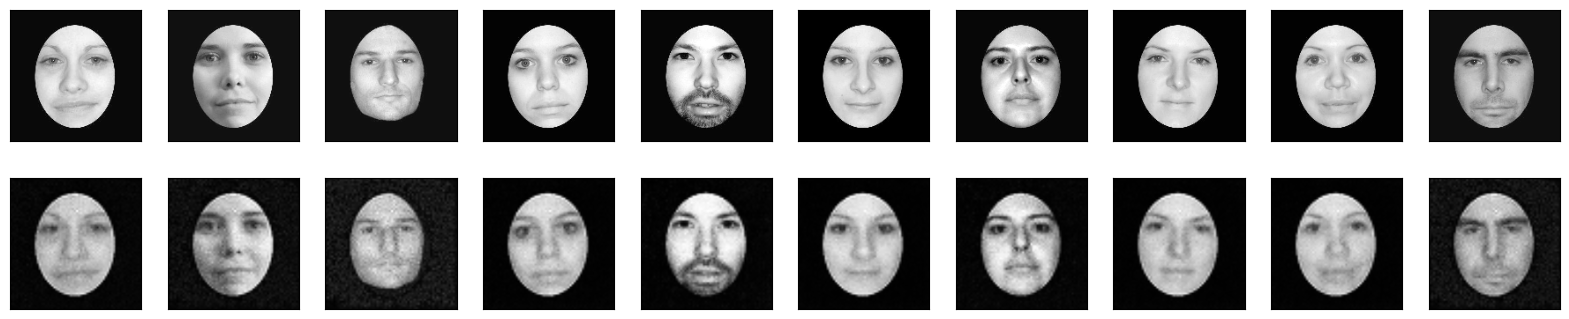

In [65]:
# Reconstruction des images à partir des représentations latentes
reconstructed_white = model.predict(white)

# Affichage des images originales et reconstruites
import matplotlib.pyplot as plt

n = 10  # Nombre d'images à afficher
plt.figure(figsize=(20, 4))
for i in range(n):
    # Affichage de l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(white[i].reshape(150,150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Affichage de l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_white[i].reshape(150,150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


2/2 [==============================] - 0s 148ms/step


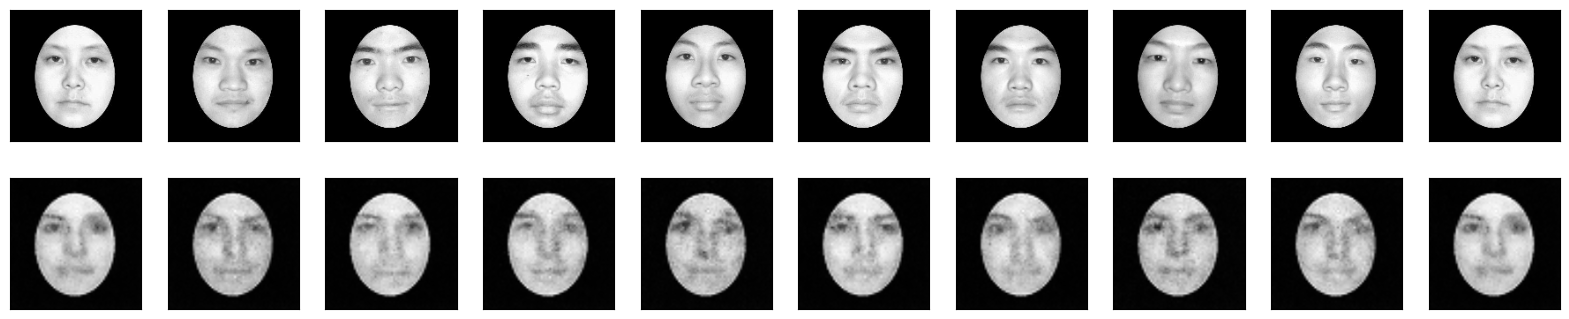

In [66]:
# Reconstruction des images à partir des représentations latentes
reconstructed_east_asian = model.predict(east_asian)

# Affichage des images originales et reconstruites
import matplotlib.pyplot as plt

n = 10  # Nombre d'images à afficher
plt.figure(figsize=(20, 4))
for i in range(n):
    # Affichage de l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(east_asian[i].reshape(150,150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Affichage de l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_east_asian[i].reshape(150,150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [67]:
import numpy as np

# Supposons que dataset1 et dataset2 sont vos ensembles de données
# dataset1.shape = (56, 150, 150)
# dataset2.shape = (56, 150, 150)

flat_recon_east_asian = reconstructed_east_asian.reshape(56, -1)
flat_recon_white = reconstructed_white.reshape(56, -1)
flat_east_asian = east_asian.reshape(56, -1)
flat_white = white.reshape(56, -1)

# Calculer les normes de chaque ensemble de données
norms_recon_east_asian = np.linalg.norm(flat_recon_east_asian, axis=1, keepdims=True)
norms_east_asian = np.linalg.norm(flat_east_asian, axis=1, keepdims=True)
norms_recon_white = np.linalg.norm(flat_recon_white, axis=1, keepdims=True)
norms_white = np.linalg.norm(flat_white, axis=1, keepdims=True)

# Calculer les produits internes entre chaque paire de vecteurs
dot_products_white = np.dot(flat_white, flat_recon_white.T)
dot_products_east_asian = np.dot(flat_east_asian, flat_recon_east_asian.T)

# Calculer les similarités cosinus
similarities_white = dot_products_white / (norms_recon_white * norms_white.T)
similarities_east_asian = dot_products_east_asian / (norms_recon_east_asian * norms_east_asian.T)

# La similarité cosinus entre dataset1 et dataset2 est une matrice de shape (56, 56)
# similarities[i, j] contient la similarité cosinus entre le i-ème vecteur de dataset1 et le j-ème vecteur de dataset2


In [68]:
# Calculer la similarité cosinus moyenne entre les ensembles de données
mean_similarity_white = np.mean(similarities_white)
mean_similarity_east_asian = np.mean(similarities_east_asian)

print("Similarité cosinus moyenne entre les ensembles de données white et reconstructed_white : ", mean_similarity_white)
print("Similarité cosinus moyenne entre les ensembles de données east_asian et reconstructed_east_asian : ", mean_similarity_east_asian)


Similarité cosinus moyenne entre les ensembles de données white et reconstructed_white :  0.97538555
Similarité cosinus moyenne entre les ensembles de données east_asian et reconstructed_east_asian :  0.9886906
